In [12]:
import pandas as pd
import plotly.express as px

# For investigating timeseries data
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt


### Importing + Visualizing Data

In [13]:
df = pd.read_csv('./Data/quarterly_data.csv', index_col=[0])
df.head(5)

,product_line,quarter,inventory
0,XYZ,2000-03-31,1017.140259
1,XYZ,2000-06-30,1219.650466
2,XYZ,2000-09-30,1064.350634
3,XYZ,2000-12-31,821.956578
4,XYZ,2001-03-31,1008.430625


In [14]:
# Graphing data
fig = px.line(df, x = 'quarter', y = 'inventory',
              title = 'Customer Inventory Over Time')
fig.show()

### Checking if Data is Stationary

In [15]:
dftest = adfuller(df['inventory'])

# Printing results
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
 print('\t%s: %.3f' % (key, value))


ADF Statistic: -0.719668
p-value: 0.841589
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586


P-value is greater than 0.05 so data is not stationary, need to difference

In [16]:
df['transformed_inventory'] = df['inventory'].diff()
# Graphing data
fig = px.line(df, x = 'quarter', y = 'transformed_inventory',
              title = 'transformed_inventory Over Time')
fig.show()

In [17]:
dftest = adfuller(df['transformed_inventory'].dropna())

# Printing results
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
 print('\t%s: %.3f' % (key, value))


ADF Statistic: -2.291021
p-value: 0.174880
Critical Values:
	1%: -3.513
	5%: -2.897
	10%: -2.586


### Now Fitting Moving Average (MA) model

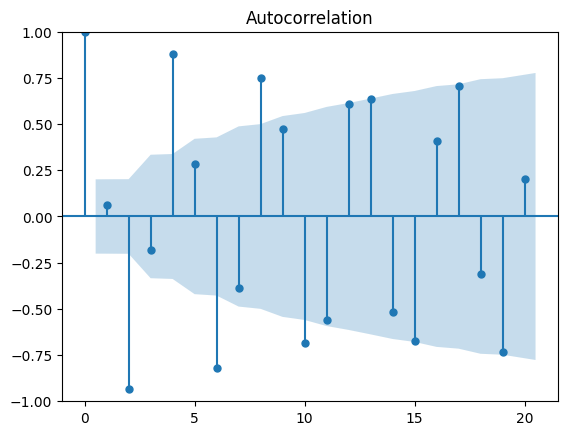

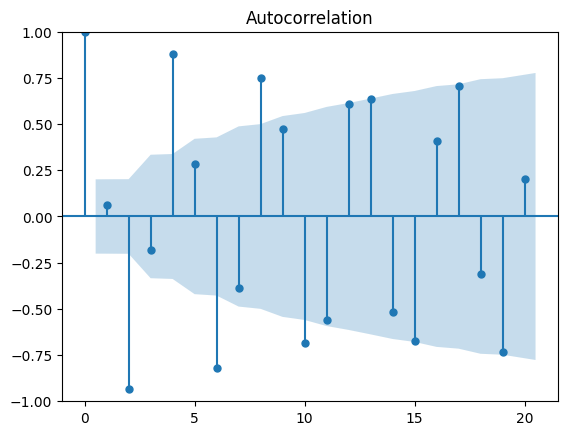

In [18]:
plot_acf(df['transformed_inventory'].dropna(), lags= 20)

### Now Training MA Model

In [19]:
def train_MA(df, train_length, steps):

    # Initializing list to store predictions
    pred_MA = []
    test = df[train_length:]

    predictions = []
    for month in range(len(test)):
        model = SARIMAX(df[:train_length + month], order= (0, 0, steps))
        model_fit = model.fit()
        output = model_fit.forecast()
        pred_MA.append(output)

    return pred_MA

# Defining train and test lengths
train_len = int(0.8 * len(df))
test_len = len(df) - train_len

# Calling function
target_varaible = 'transformed_inventory'
steps = 3
MA_predictions = train_MA(df[target_varaible], train_len, steps)
print(MA_predictions)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[76    109.403429
dtype: float64, 77   -119.627711
dtype: float64, 78   -147.633539
dtype: float64, 79    13.622467
dtype: float64, 80    136.882308
dtype: float64, 81    62.492543
dtype: float64, 82   -170.5203
dtype: float64, 83    20.116742
dtype: float64, 84    98.060087
dtype: float64, 85   -25.266196
dtype: float64, 86   -107.718594
dtype: float64, 87   -90.604654
dtype: float64, 88    18.953858
dtype: float64, 89    101.134882
dtype: float64, 90   -243.590409
dtype: float64, 91   -80.367122
dtype: float64, 92    42.861606
dtype: float64, 93    124.956044
dtype: float64, 94   -82.112758
dtype: float64, 95   -198.99166
dtype: float64]


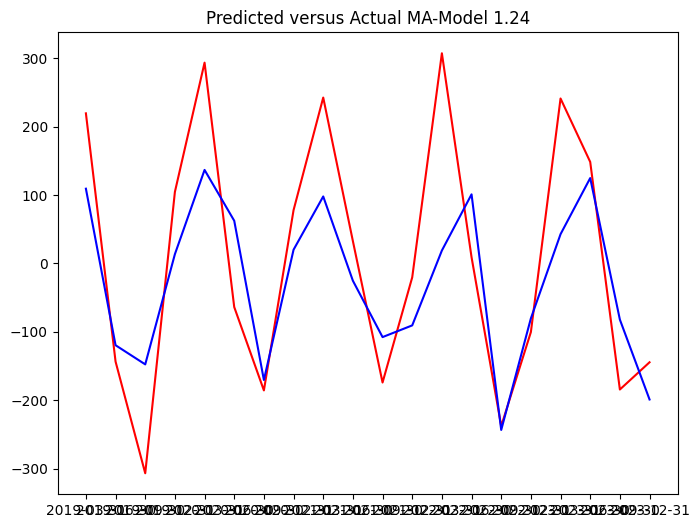

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
MA_mape = mean_absolute_percentage_error(df[target_varaible][train_len:], MA_predictions)

# Actual Values
ax.plot(df['quarter'][train_len:], 
        df[target_varaible][train_len:], color='RED')

# Predicted values
ax.plot(df['quarter'][train_len:],
      MA_predictions, color='BLUE')

ax.set_title("Predicted versus Actual MA-Model " + str(round(MA_mape, 2)))
plt.show()

### Now Finding Best MA Model